# Pectoral Muscle Removal

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from bcd.utils.visual import plot_images
from bcd.utils.image import grayscale, grayscale
from bcd.preprocess.image import Resizer

In [2]:
img1 = "data/image/1_dev/converted/train/benign/82dcf0a8-cfb0-4446-97e4-a561893e334b.png"
img2 = "data/image/1_dev/converted/train/benign/2a458310-ed63-46ed-b18a-3e9790e2c182.png"
img3 = "data/image/1_dev/converted/train/malignant/7dcc12fd-88f0-4048-a6ab-5dd0bd836f08.png"
img4 = "data/image/1_dev/converted/train/benign/a2c62f57-14c7-4ac1-b763-b18797847af0.png"

## Original Image

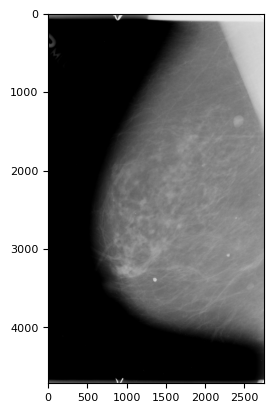

In [3]:
img = cv2.imread(img1)
plt.imshow(img)

In [4]:
width = 256
height = 256
dim = (width, height)
# img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

img = grayscale(img)
r = Resizer(keep_aspect=False)
img = r.run(img)
r,c  = img.shape
hyp = np.sqrt(r**2+c**2)
img.shape


INFO:bcd.utils.profile:Profiling


(256, 256)

## Right Flip

In [5]:
def right_flip(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]*.10)][0])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]*.90):][0])
    print(left_nonzero)
    print(right_nonzero)
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)
    return image    
img = right_flip(img)

25
26


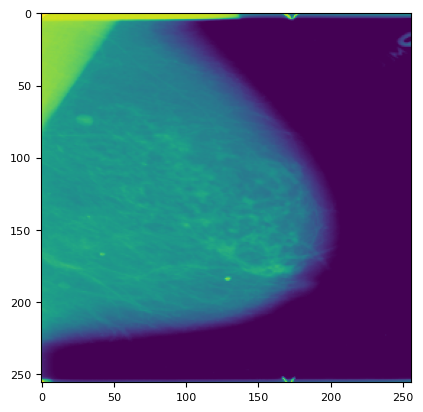

In [6]:
plt.imshow(img)

## Canny Edge Detection

In [7]:
def canny(image, auto: bool = False, sigma: float =0.1, lower: int = 50, upper: int = 200):
    if auto:
        # compute the median of the single channel pixel intensities
        v = np.median(image)
        # apply automatic Canny edge detection using the computed median
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(np.max(image)-1, (1.0 + sigma) * v))	
        print(f"Lower: {lower} Upper: {upper}")
        edged = cv2.Canny(image, threshold1=lower, threshold2=upper, L2gradient=True)
    else:
        edged = cv2.Canny(image, threshold1=lower, threshold2=upper, L2gradient=True)        
	# return the edged image
    return edged

In [8]:
blurred = cv2.GaussianBlur(img, (5,5), 0)

In [9]:
edges = canny(blurred, auto=True)

Lower: 71 Upper: 86


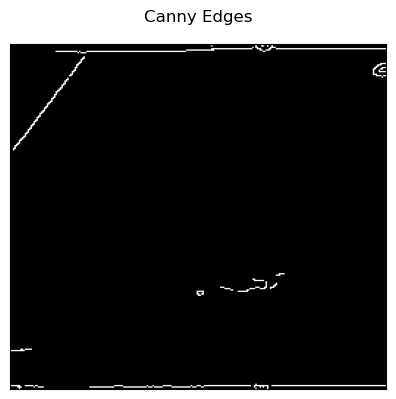

In [10]:
_ = plot_images([edges], title="Canny Edges")

## Hough Line Transformation

In [11]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = r
    shortlisted_lines = [x for x in lines if 
                          (x['rho']>=MIN_DIST) &
                          (x['rho']<=MAX_DIST) &
                          (x['theta']>=MIN_ANGLE) &
                          (x['theta']<=MAX_ANGLE)
                        ]
    return shortlisted_lines

In [12]:
def shortlist_line(line):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = r
    return (line['rho']>=MIN_DIST) & (line['rho']<=MAX_DIST) & (line['theta']>=MIN_ANGLE) & (line['theta']<=MAX_ANGLE)    


Num lines: 11
Num Short Listed lines: 2


[{'rho': 46.0,
  'theta': 34.999996,
  'point1': [-535, 845],
  'point2': [611, -792]},
 {'rho': 47.0, 'theta': 36.0, 'point1': [-549, 836], 'point2': [625, -781]}]

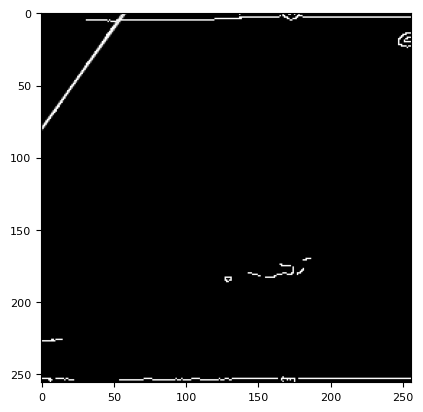

In [13]:
#lines = cv2.HoughLines(image=edges,rho=1,theta=np.pi/180,threshold=80, min_theta=np.pi/18,max_theta=np.pi/2.5)
lines = cv2.HoughLines(image=edges,rho=1,theta=np.pi/180,threshold=50)
line_list = []
edges_lines = edges.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
    x1 = int(x0 + 1000*(-b))
 
    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
    y1 = int(y0 + 1000*(a))
 
    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
    x2 = int(x0 - 1000*(-b))
 
    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
    y2 = int(y0 - 1000*(a))
    line = {'rho': rho, 'theta': np.degrees(theta), 'point1': [x1,y1], 'point2': [x2,y2]}
    line_list.append(line)    
    if shortlist_line(line):
        edges_lines= cv2.line(edges_lines, (x1,y1), (x2,y2), color=255, thickness= 1, lineType= cv2.LINE_AA)


plt.imshow(edges_lines, cmap='gray')
print(f"Num lines: {len(line_list)}")
slines = shortlist_lines(line_list)
print(f"Num Short Listed lines: {len(slines)}")
slines

## Remove Pectoral

In [14]:
def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['rho'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['rho']
    print(pectoral_line)
    theta = np.radians(pectoral_line['theta'])
    x_intercept = min(d/np.cos(theta),255)  
    y_intercept = min(d/np.sin(theta),255)
    rr, cc = polygon([0, 0, y_intercept], [0, x_intercept, 0])
    return rr, cc
    

{'rho': 46.0, 'theta': 34.999996, 'point1': [-535, 845], 'point2': [611, -792]}


array([ 0,  0,  0, ..., 78, 79, 80])

array([0, 1, 2, ..., 1, 0, 0])

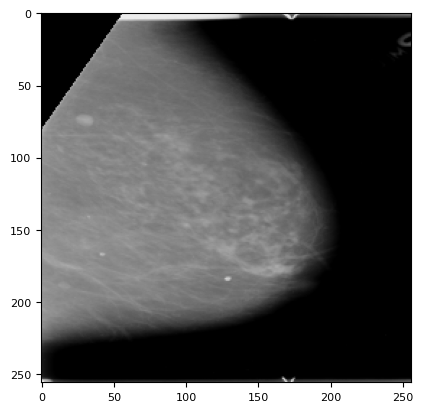

In [15]:
rr,cc = remove_pectoral(shortlisted_lines=slines)
rr
cc
img[rr,cc] = 0
plt.imshow(img, cmap='gray')
